## Train SAEs on different datasets

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, time

In [105]:
#parameters
MODEL_NONLINEARITY = "sparsemax_dist" #one of "relu","topk", "sparsemax_lintx", "sparsemax_dist"
DATASET = "shape" #one of "linear", "spiral", "shape"
NUMNEURONS = 20
topK = 5 #only used if MODEL_NONLINEARITY == "topk"
NUMEPOCHS = 100

EXPERIMENT_NAME = MODEL_NONLINEARITY+"_"+DATASET+"_"+str(NUMNEURONS)+"neurons"
folder = './experiments/'+EXPERIMENT_NAME+'/'
import os
if not os.path.exists(folder):
    os.makedirs(folder)


In [106]:
dataloc = f"./data"
from data_prep import loaddata
train_dataloader, test_dataloader = loaddata(DATASET, root=dataloc, batch_size=64, normalize=True)

In [107]:
#define model, initialize with standard normal weights
torch.manual_seed(0)

from models import Net
dim = 2
model =  Net(dim, NUMNEURONS,dim, nonlinearity=MODEL_NONLINEARITY, topk=topK)

torch.manual_seed(0)
A = torch.randn_like(model.fc1.weight)
b = torch.randn_like(model.fc1.bias)
with torch.no_grad():
    model.fc1.weight.copy_(A)
    model.fc1.bias.copy_(b)

In [108]:
#train the model
trainloss_mse = []
trainloss_reg = []

testloss_mse = []
testloss_reg = []

lambda_values = []
lambda_values.append(model.lambda_val.item())
#save model at init
# torch.save({'model':model.state_dict()}, folder+"model_init"+'.pt')

optimizer = torch.optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUMEPOCHS) #defined but not used if args.scheduler=="None"

for k in range(NUMEPOCHS):
    model.train()
    loss_track_mse = 0
    loss_track_reg = 0
    for x, y in train_dataloader:
        xhat, hidden = model(x,return_hidden=True)
        mse = torch.mean(torch.sum(torch.pow(xhat-x, 2), dim=-1))
        if MODEL_NONLINEARITY != "sparsemax_dist":
            reg = torch.mean(torch.sum(torch.abs(hidden), dim=-1))
        else:
            dist_penalty = (x.unsqueeze(1)-model.fc1.weight.unsqueeze(0)).pow(2).sum(dim=-1)
            reg = (dist_penalty*hidden).sum(dim=-1).mean()
        gamma = 0.1
        loss = mse + gamma*reg
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        loss_track_mse += mse.item()
        loss_track_reg += reg.item()
    trainloss_mse.append(loss_track_mse/len(train_dataloader))
    trainloss_reg.append(loss_track_reg/len(train_dataloader))
    lambda_values.append(model.lambda_val.item())
    with torch.no_grad():
        loss_track_mse = 0
        loss_track_reg = 0
        for x,y in test_dataloader:
            
            xhat, hidden = model(x,return_hidden=True)
            mse = torch.mean(torch.sum(torch.pow(xhat-x, 2), dim=-1))
            if MODEL_NONLINEARITY != "sparsemax_dist":
                reg = torch.mean(torch.sum(torch.abs(hidden), dim=-1))
            else:
                dist_penalty = (x.unsqueeze(1)-model.fc1.weight.unsqueeze(0)).pow(2).sum(dim=-1)
                reg = (dist_penalty*hidden).sum(dim=-1).mean()
            gamma = 0.1
            loss = mse + gamma*reg
            loss_track_mse += mse.item()
            loss_track_reg += reg.item()
        testloss_mse.append(loss_track_mse/len(test_dataloader))
        testloss_reg.append(loss_track_reg/len(test_dataloader))
#save model after training
# torch.save({'model':model.state_dict()}, folder+"model_final"+'.pt')
# torch.save({'trainloss_mse':trainloss_mse, 'trainloss_reg':trainloss_reg, \
#     'testloss_mse':testloss_mse, 'testloss_reg':testloss_reg, \
#         'lambda_values':lambda_values}, folder+"losses"+'.pt')

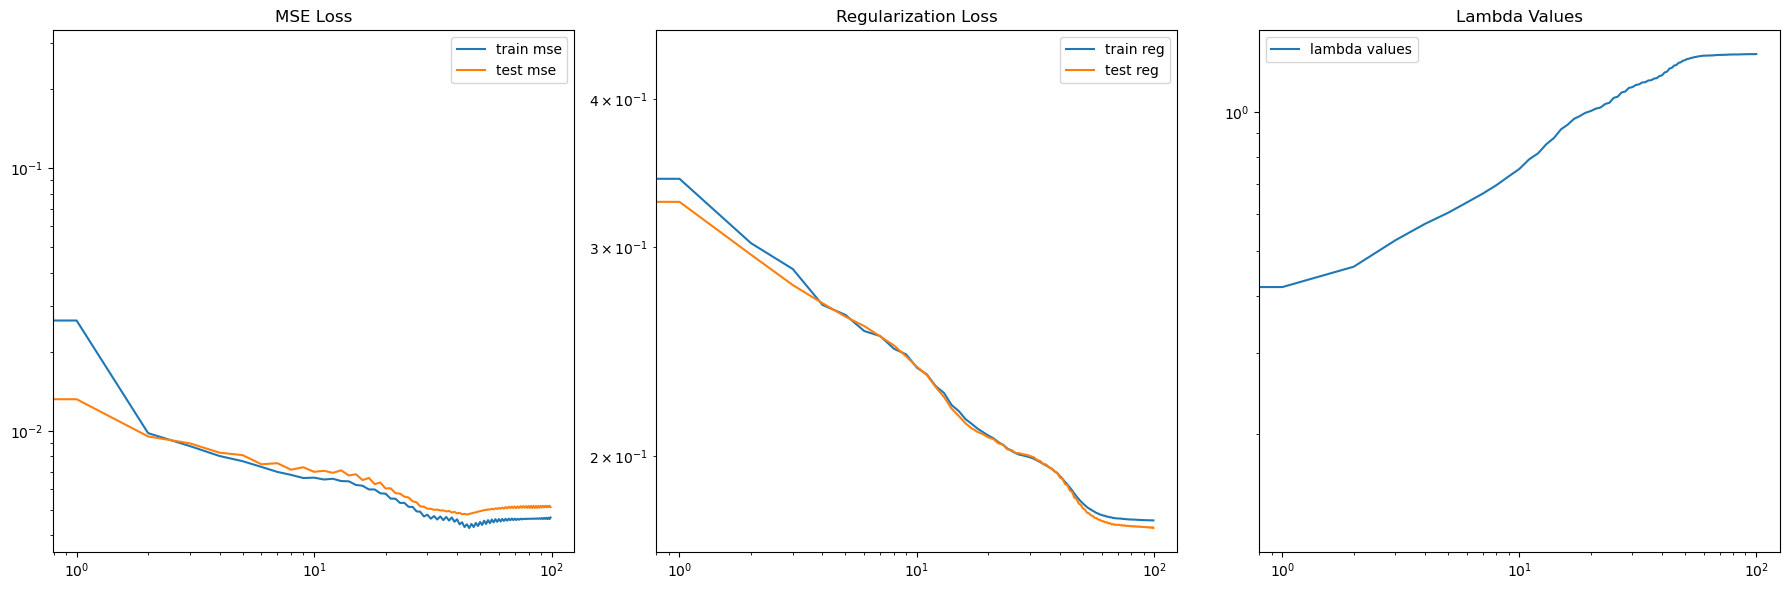

In [109]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.plot(trainloss_mse, label="train mse")
ax1.plot(testloss_mse, label="test mse")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('MSE Loss')
ax1.legend()

ax2.plot(trainloss_reg, label="train reg")
ax2.plot(testloss_reg, label="test reg")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Regularization Loss')
ax2.legend()

ax3.plot(lambda_values, label="lambda values")
ax3.set_xscale('log')
ax3.set_title('Lambda Values')
ax3.legend()

plt.tight_layout()
plt.xscale('log')
plt.yscale('log')
plt.legend()